In [9]:
import os
import copy
import math
import typing
import cv2
import imageio.v2 as iio
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import timm.layers as timmm

figure_path = '/Users/davidfarache/Documents/ML-ToolBox/VisionTransformers/TransformerFiles'

# SoftSplit Example:

Mountain at Dusk is H = 60 and W = 100 pixels.




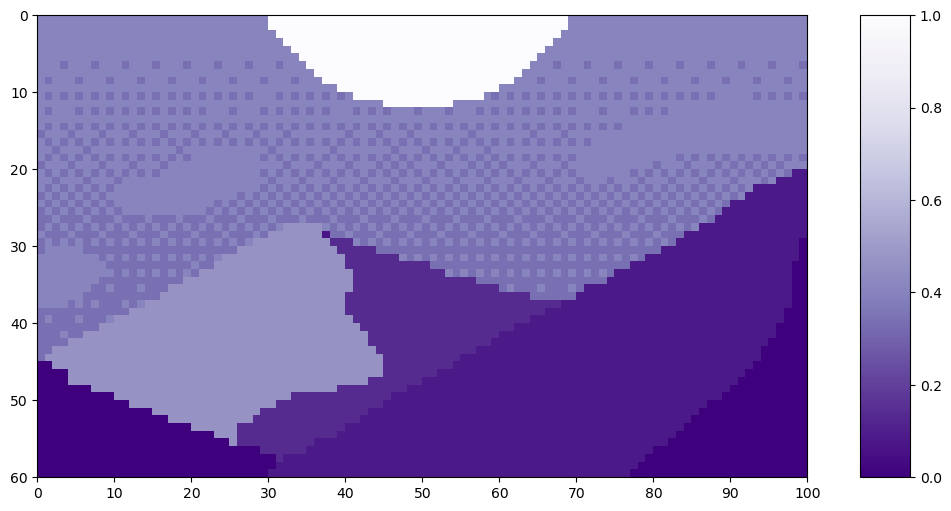

In [10]:
# Image for example
mountains = np.load(os.path.join(figure_path, 'mountains.npy'))

H = mountains.shape[0]
W = mountains.shape[1]
print('Mountain at Dusk is H =', H, 'and W =', W, 'pixels.')
print('\n')

fig = plt.figure(figsize=(10,6))
plt.imshow(mountains, cmap='Purples_r')
plt.xticks(np.arange(-0.5, W+1, 10), labels=np.arange(0, W+1, 10))
plt.yticks(np.arange(-0.5, H+1, 10), labels=np.arange(0, H+1, 10))
plt.clim([0,1])
cbar_ax = fig.add_axes([0.95, .11, 0.05, 0.77])
plt.clim([0, 1])
plt.colorbar(cax=cbar_ax);
#plt.savefig(os.path.join(figure_path, 'mountains.png'), bbox_inches='tight')

In [11]:
def count_tokens(w, h, k, s, p):
	""" Function to count how many tokens are produced from a given soft split

		Args:
			w (int): starting width
			h (int): starting height
			k (int): kernel size
			s (int): stride size
			p (int): padding size

		Returns:
			new_w (int): number of tokens along the width
			new_h (int): number of tokens along the height
			total (int): total number of tokens created
	"""

	new_w = int(math.floor(((w + 2*p -1*(k-1) -1)/s)+1))
	new_h = int(math.floor(((h + 2*p -1*(k-1) -1)/s)+1))
	total = new_w * new_h

	return new_w, new_h, total

k = 20
s = 10
p = 5
padded_H = H + 2*p
padded_W = W + 2*p
print('With padding, the image will be H =', padded_H, 'and W =', padded_W, 'pixels.\n') 

patches_w, patches_h, total_patches = count_tokens(w=W, h=H, k=k, s=s, p=p)
print('There will be', total_patches, 'patches as a result of the soft split;')
print(patches_h, 'along the height and', patches_w, 'along the width.')

With padding, the image will be H = 70 and W = 110 pixels.

There will be 60 patches as a result of the soft split;
6 along the height and 10 along the width.


In [17]:
mountains_w_padding = np.pad(mountains, pad_width = ((p, p), (p, p)), mode='constant', constant_values=0)

left_x = np.tile(np.arange(-0.5, padded_W-k+1, s), patches_h)
right_x = np.tile(np.arange(k-0.5, padded_W+1, s), patches_h)
top_y = np.repeat(np.arange(-0.5, padded_H-k+1, s), patches_w)
bottom_y = np.repeat(np.arange(k-0.5, padded_H+1, s), patches_w)

frame_paths = []

for i in range(total_patches):
    fig = plt.figure(figsize=(10,6))
    plt.imshow(mountains_w_padding, cmap='Purples_r')
    plt.clim([0,1])
    plt.xticks(np.arange(-0.5, W+2*p+1, 10), labels=np.arange(0, W+2*p+1, 10))
    plt.yticks(np.arange(-0.5, H+2*p+1, 10), labels=np.arange(0, H+2*p+1, 10))

    plt.plot([left_x[i], left_x[i], right_x[i], right_x[i], left_x[i]], [top_y[i], bottom_y[i], bottom_y[i], top_y[i], top_y[i]], color='w', lw=3, ls='-')

    for j in range(i):
        plt.plot([left_x[j], left_x[j], right_x[j], right_x[j], left_x[j]], [top_y[j], bottom_y[j], bottom_y[j], top_y[j], top_y[j]], color='w', lw=2, ls=':', alpha=0.5)
    save_path = os.path.join(figure_path, 'softsplit_gif', 'frame{:02d}'.format(i))+'.png'
    frame_paths.append(save_path)
    #fig.savefig(save_path, bbox_inches='tight')
    plt.close()
    
frames = []
for path in frame_paths:
    frames.append(iio.imread(path))

#iio.mimsave(os.path.join(figure_path, 'softsplit.gif'), frames, fps=2, loop=0)

Each patch will make a token of length 400.




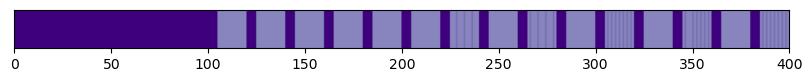

In [18]:
print('Each patch will make a token of length', str(k**2)+'.')
print('\n')

patch = mountains_w_padding[0:20, 0:20]
token = patch.reshape(1, k**2,)

fig = plt.figure(figsize=(10,1))
plt.imshow(token, cmap='Purples_r', aspect=20)
plt.clim([0, 1])
plt.xticks(np.arange(-0.5, k**2+1, 50), labels=np.arange(0, k**2+1, 50))
plt.yticks([]);
#plt.savefig(os.path.join(figure_path, 'mountains_w_padding_token01.png'), bbox_inches='tight')

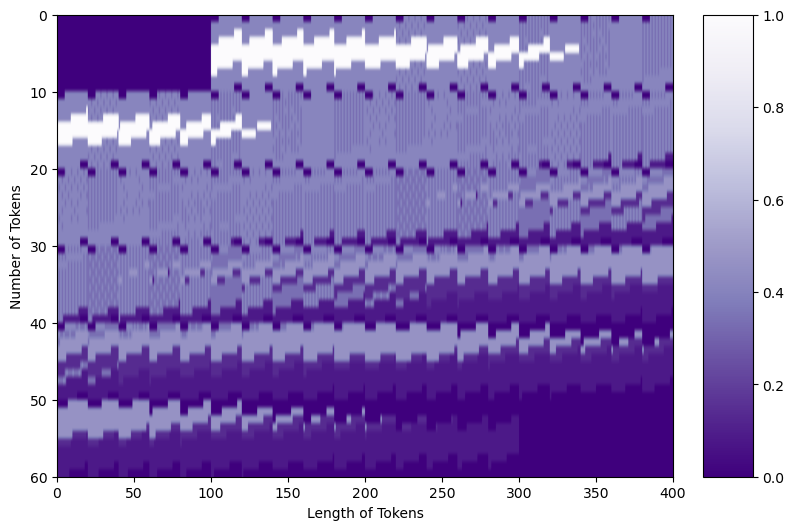

In [19]:
left_x = np.tile(np.arange(0, padded_W-k+1, s), patches_h)
right_x = np.tile(np.arange(k, padded_W+1, s), patches_h)
top_y = np.repeat(np.arange(0, padded_H-k+1, s), patches_w)
bottom_y = np.repeat(np.arange(k, padded_H+1, s), patches_w)

tokens = np.zeros((total_patches, k**2))
for i in range(total_patches):
    patch = mountains_w_padding[top_y[i]:bottom_y[i], left_x[i]:right_x[i]]
    tokens[i, :] = patch.reshape(1, k**2)
    
fig = plt.figure(figsize=(10,6))
plt.imshow(tokens, cmap='Purples_r', aspect=5)
plt.clim([0, 1])
plt.xticks(np.arange(-0.5, k**2+1, 50), labels=np.arange(0, k**2+1, 50))
plt.yticks(np.arange(-0.5, total_patches+1, 10), labels=np.arange(0, total_patches+1, 10))
plt.xlabel('Length of Tokens')
plt.ylabel('Number of Tokens')
plt.clim([0,1])
cbar_ax = fig.add_axes([0.85, .11, 0.05, 0.77])
plt.clim([0, 1])
plt.colorbar(cax=cbar_ax);
#plt.savefig(os.path.join(figure_path, 'mountains_w_padding_tokens_matrix.png'), bbox_inches='tight')

# Token Transformer Code

In [25]:
class Attention(nn.Module):
    def __init__(self, 
                dim: int,
                chan: int,
                num_heads: int=1,
                qkv_bias: bool=False,
                qk_scale: NoneFloat=None):

        """ Attention Module

            Args:
                dim (int): input size of a single token
                chan (int): resulting size of a single token (channels)
                num_heads(int): number of attention heads in MSA (only works if =1)
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
        """

        super().__init__()

        ## Define Constants
        self.num_heads = num_heads
        self.chan = chan
        self.head_dim = self.chan // self.num_heads
        self.scale = qk_scale or self.head_dim ** -0.5

        ## Define Layers
        self.qkv = nn.Linear(dim, chan * 3, bias=qkv_bias)
        ## Each token gets projected from starting token_len to channel length 3 times (once for each Q,K,V)
        self.proj = nn.Linear(chan, chan)

    def forward(self, x):
        if self.chan % self.num_heads != 0:
            raise ValueError('"Chan" must be evenly divisible by "num_heads".')
        B, N, C = x.shape
        ## Dimensions: (batch, num_tokens, token_len)

        ## Calcuate QKVs
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        ## Dimensions: (qkv, batch, heads, num_tokens, token_len = chan/num_heads = head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        ## Calculate Attention
        attn = (q * self.scale) @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        ## Dimensions: (batch, heads, num_tokens, num_tokens)

        ## Attention Layer
        x = (attn @ v).transpose(1, 2).reshape(B, N, self.chan)
        ## Dimensions: (batch, heads, num_tokens, token_len = chan)

        ## Projection Layers
        x = self.proj(x)

        ## Skip Connection Layer
        v = v.transpose(1, 2).reshape(B, N, self.chan)
        x = v + x     
        ## Because the original x has different size with current x, use v to do skip connection

        return x

In [26]:
class NeuralNet(nn.Module):
    def __init__(self,
    			in_chan: int,
    			hidden_chan: NoneFloat=None,
    			out_chan: NoneFloat=None,
    			act_layer = nn.GELU):
        """ Neural Network Module

            Args:
                in_chan (int): number of channels (features) at input
                hidden_chan (NoneFloat): number of channels (features) in the hidden layer;
                                        if None, number of channels in hidden layer is the same as the number of input channels
                out_chan (NoneFloat): number of channels (features) at output;
                                        if None, number of output channels is same as the number of input channels
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
        """

        super().__init__()

        ## Define Number of Channels
        hidden_chan = hidden_chan or in_chan
        out_chan = out_chan or in_chan

        ## Define Layers
        self.fc1 = nn.Linear(in_chan, hidden_chan)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_chan, out_chan)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

# Token Transformer

In [27]:
NoneFloat = typing.Union[None, float]

class TokenTransformer(nn.Module):

    def __init__(self,
       dim: int,
       chan: int,
       num_heads: int,
       hidden_chan_mul: float=1.,
       qkv_bias: bool=False,
       qk_scale: NoneFloat=None,
       act_layer=nn.GELU,
       norm_layer=nn.LayerNorm):

        """ Token Transformer Module

            Args:
                dim (int): size of a single token
                chan (int): resulting size of a single token 
                num_heads (int): number of attention heads in MSA 
                hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet module
                qkv_bias (bool): determines if the attention qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
                act_layer(nn.modules.activation): torch neural network layer class to use as activation in the NeuralNet module
                norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
        """

        super().__init__()

        ## Define Layers
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim,
              chan=chan,
              num_heads=num_heads,
              qkv_bias=qkv_bias,
              qk_scale=qk_scale)
        self.norm2 = norm_layer(chan)
        self.neuralnet = NeuralNet(in_chan=chan,
              hidden_chan=int(chan*hidden_chan_mul),
              out_chan=chan,
              act_layer=act_layer)

    def forward(self, x):
        x = self.attn(self.norm1(x))
        x = x + self.neuralnet(self.norm2(x))
        return x

In [28]:
# Define an Input
token_len = 7*7
channels = 64
num_tokens = 100
batch = 13
heads = 4
x = torch.rand(batch, num_tokens, token_len)
print('Input dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])

# Define the Module
TT = TokenTransformer(dim=token_len, 
                      chan=channels, 
                      num_heads=heads, 
                      hidden_chan_mul=1.5, 
                      qkv_bias=False, 
                      qk_scale=None, 
                      act_layer=nn.GELU, 
                      norm_layer=nn.LayerNorm)
TT.eval();

Input dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 49


In [30]:
# Pass the input through a norm layer, which does not change it's shape
x = TT.norm1(x)
print('After norm, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])
x = TT.attn(x)
print('After attention, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])

After norm, dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 49
After attention, dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 64


In [31]:
y = TT.norm2(x)
print('After norm, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])
y = TT.neuralnet(y)
print('After neural net, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])
y = y + x
print('After split connection, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])

After norm, dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 64
After neural net, dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 64
After split connection, dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 64


In [29]:
class NeuralNet(nn.Module):
    def __init__(self,
       in_chan: int,
       hidden_chan: NoneFloat=None,
       out_chan: NoneFloat=None,
       act_layer = nn.GELU):
        """ Neural Network Module

            Args:
                in_chan (int): number of channels (features) at input
                hidden_chan (NoneFloat): number of channels (features) in the hidden layer;
                                        if None, number of channels in hidden layer is the same as the number of input channels
                out_chan (NoneFloat): number of channels (features) at output;
                                        if None, number of output channels is same as the number of input channels
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
        """

        super().__init__()

        ## Define Number of Channels
        hidden_chan = hidden_chan or in_chan
        out_chan = out_chan or in_chan

        ## Define Layers
        self.fc1 = nn.Linear(in_chan, hidden_chan)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_chan, out_chan)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x